In [9]:
import os
import cv2
from tqdm import tqdm
import string
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.cluster.hierarchy import fcluster, linkage
from PIL import Image

In [10]:
IMAGE_FOLDER = '../data/tablenet_data/images/4. Cropped'
MASK_FOLDER = '../data/tablenet_data/masking/4. Cropped Masks'
MODEL_FILE = 'trained_model/tablenet_model.h5'

ANNOTATION_TYPES = ["cell", "information"]

In [5]:
model = tf.keras.models.load_model(MODEL_FILE)

In [6]:
def load_image(image_input, input_shape):
    """
    Load and preprocess an image for the model.

    Args:
        image_input (str): Path to the input image file.
        input_shape (tuple): Target shape for the model input.

    Returns:
        tuple: Original image, preprocessed image.
    """
    if isinstance(image_input, str):
        image = tf.io.read_file(image_input)
    else:
        raise ValueError("Image input must be a file path.")
    image = tf.image.decode_jpeg(image, channels=3)
    image_resized = tf.image.resize(image, (input_shape[0], input_shape[1]))
    return image, tf.cast(image_resized, tf.float32) / 255.0

In [14]:
def predict_and_save(model, image_folder, cell_output_folder, information_output_folder, input_shape, thresholds):
    """
    Predict cell and information outputs for images in a folder, apply thresholds, and save results as black-and-white masks.

    Args:
        model (tf.keras.Model): Loaded TensorFlow/Keras model.
        image_folder (str): Path to the folder containing input images.
        cell_output_folder (str): Path to save cell output masks.
        information_output_folder (str): Path to save information output masks.
        input_shape (tuple): Input shape expected by the model.
        thresholds (dict): Threshold values for "cell" and "information".

    Returns:
        None
    """
    os.makedirs(cell_output_folder, exist_ok=True)
    os.makedirs(information_output_folder, exist_ok=True)

    # Process each image in the folder
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    for image_file in tqdm(image_files, desc="Processing images", unit="image"):
        # Load and preprocess the image
        image_path = os.path.join(image_folder, image_file)
        try:
            original_image, preprocessed_image = load_image(image_path, input_shape)
        except Exception as e:
            tqdm.set_postfix({"status": f"Failed to load {image_file}"})
            continue

        # Add batch dimension and predict
        preprocessed_image = tf.expand_dims(preprocessed_image, axis=0)  # Add batch dimension
        cell_output, information_output = model.predict(preprocessed_image, verbose=0)  # Suppress verbose logs

        # Apply thresholds
        cell_mask = (np.squeeze(cell_output) > thresholds["cell"]).astype(np.uint8) * 255  # Apply threshold to cell output
        information_mask = (np.squeeze(information_output) > thresholds["information"]).astype(np.uint8) * 255  # Apply threshold to information output

        # Convert to PIL Images
        cell_image = Image.fromarray(cell_mask, mode="L")  # "L" ensures grayscale
        information_image = Image.fromarray(information_mask, mode="L")

        # Save the masks
        cell_output_path = os.path.join(cell_output_folder, f"{os.path.splitext(image_file)[0]}.png")
        information_output_path = os.path.join(information_output_folder, f"{os.path.splitext(image_file)[0]}.png")

        cell_image.save(cell_output_path)
        information_image.save(information_output_path)

In [17]:
# Parameters
image_folder = "../data/tablenet_data/results/images"
cell_output_folder = "../data/tablenet_data/results/masks/cell"
information_output_folder = "../data/tablenet_data/results/masks/information"
input_shape = (1824, 1760)

# Thresholds for cell and information
thresholds = {
    "cell": 0.8,
    "information": 0.4
}

# Run the prediction and export process
predict_and_save(model, image_folder, cell_output_folder, information_output_folder, input_shape, thresholds)

Processing images: 100%|██████████| 633/633 [1:35:05<00:00,  9.01s/image]


---

In [5]:
def get_information_bounding_boxes(pred_mask, padding=5, input_shape=None, original_shape=None, min_width=10, min_height=10):
    contours, _ = cv2.findContours(pred_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = []
    for (x, y, w, h) in [cv2.boundingRect(contour) for contour in contours]:
        if w >= min_width and h >= min_height:
            x = max(0, x - padding)
            y = max(0, y - padding)
            w = min(w + 2 * padding, input_shape[1] - x)
            h = min(h + 2 * padding, input_shape[0] - y)
            if original_shape:
                x = int(x * original_shape[1] / input_shape[1])
                y = int(y * original_shape[0] / input_shape[0])
                w = int(w * original_shape[1] / input_shape[1])
                h = int(h * original_shape[0] / input_shape[0])
            bounding_boxes.append((x, y, w, h))
    return bounding_boxes

In [6]:
def get_cell_polygons(cell_mask, min_area=50, epsilon_factor=0.001, padding_top=5, padding_bottom=5):
    contours, _ = cv2.findContours(cell_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    for contour in contours:
        if cv2.contourArea(contour) >= min_area:
            epsilon = epsilon_factor * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            approx = approx.squeeze()

            if approx.ndim == 2:
                approx[:, 1] = np.clip(approx[:, 1] - padding_top, 0, cell_mask.shape[0]) 
                approx[:, 1] = np.clip(approx[:, 1] + padding_bottom, 0, cell_mask.shape[0])

            polygons.append(approx)
    return polygons

In [7]:
def enhance_cell_mask(cell_mask, min_line_length=50, max_line_gap=5):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    closed_mask = cv2.morphologyEx(cell_mask, cv2.MORPH_CLOSE, kernel)

    edges = cv2.Canny(closed_mask, 50, 150)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=min_line_length, maxLineGap=max_line_gap)

    enhanced_mask = closed_mask.copy()
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(enhanced_mask, (x1, y1), (x2, y2), 255, thickness=1)

    return enhanced_mask

In [8]:
def visualize_uploaded_image_with_polygons(model, input_shape, thresholds, image_input=None):
    image, image_resized_norm = load_image(image_input, input_shape)
    image_resized_norm = tf.expand_dims(image_resized_norm, axis=0)
    predictions = model.predict(image_resized_norm)

    processed_masks = {annotation_type: (predictions[ANNOTATION_TYPES.index(annotation_type)] > thresholds[annotation_type]).astype(np.uint8).squeeze() for annotation_type in thresholds}

    cell_mask = processed_masks["cell"]
    enhanced_cell_mask = enhance_cell_mask(cell_mask, min_line_length=50, max_line_gap=5)

    cell_polygons = get_cell_polygons(enhanced_cell_mask, min_area=50, epsilon_factor=0.001, padding_top=1, padding_bottom=1)

    information_mask = processed_masks["information"]
    information_boxes = get_information_bounding_boxes(information_mask, padding=5, input_shape=input_shape, original_shape=image.shape)

    original_image_with_info_boxes = image.numpy()
    original_image_with_cell_polygons = image.numpy()

    for (x, y, w, h) in information_boxes:
        cv2.rectangle(original_image_with_info_boxes, (x, y), (x + w, y + h), (255, 0, 0), 2)

    for polygon in cell_polygons:
        if len(polygon.shape) == 2:
            cv2.drawContours(original_image_with_cell_polygons, [polygon], -1, (0, 255, 0), 2)

    plt.figure(figsize=(25, 10))
    plt.subplot(1, 5, 1)
    plt.imshow(tf.image.convert_image_dtype(image, tf.uint8).numpy())
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 5, 2)
    plt.imshow(cv2.cvtColor(original_image_with_cell_polygons, cv2.COLOR_BGR2RGB))
    plt.title("Original Image with Enhanced Cell Polygons")
    plt.axis("off")

    plt.subplot(1, 5, 3)
    plt.imshow(cv2.cvtColor(original_image_with_info_boxes, cv2.COLOR_BGR2RGB))
    plt.title("Original Image with Information Bounding Boxes")
    plt.axis("off")

    plt.subplot(1, 5, 4)
    plt.imshow(cell_mask, cmap="gray")
    plt.title("Original Cell Mask")
    plt.axis("off")

    plt.subplot(1, 5, 5)
    plt.imshow(enhanced_cell_mask, cmap="gray")
    plt.title("Enhanced Cell Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return cell_polygons


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


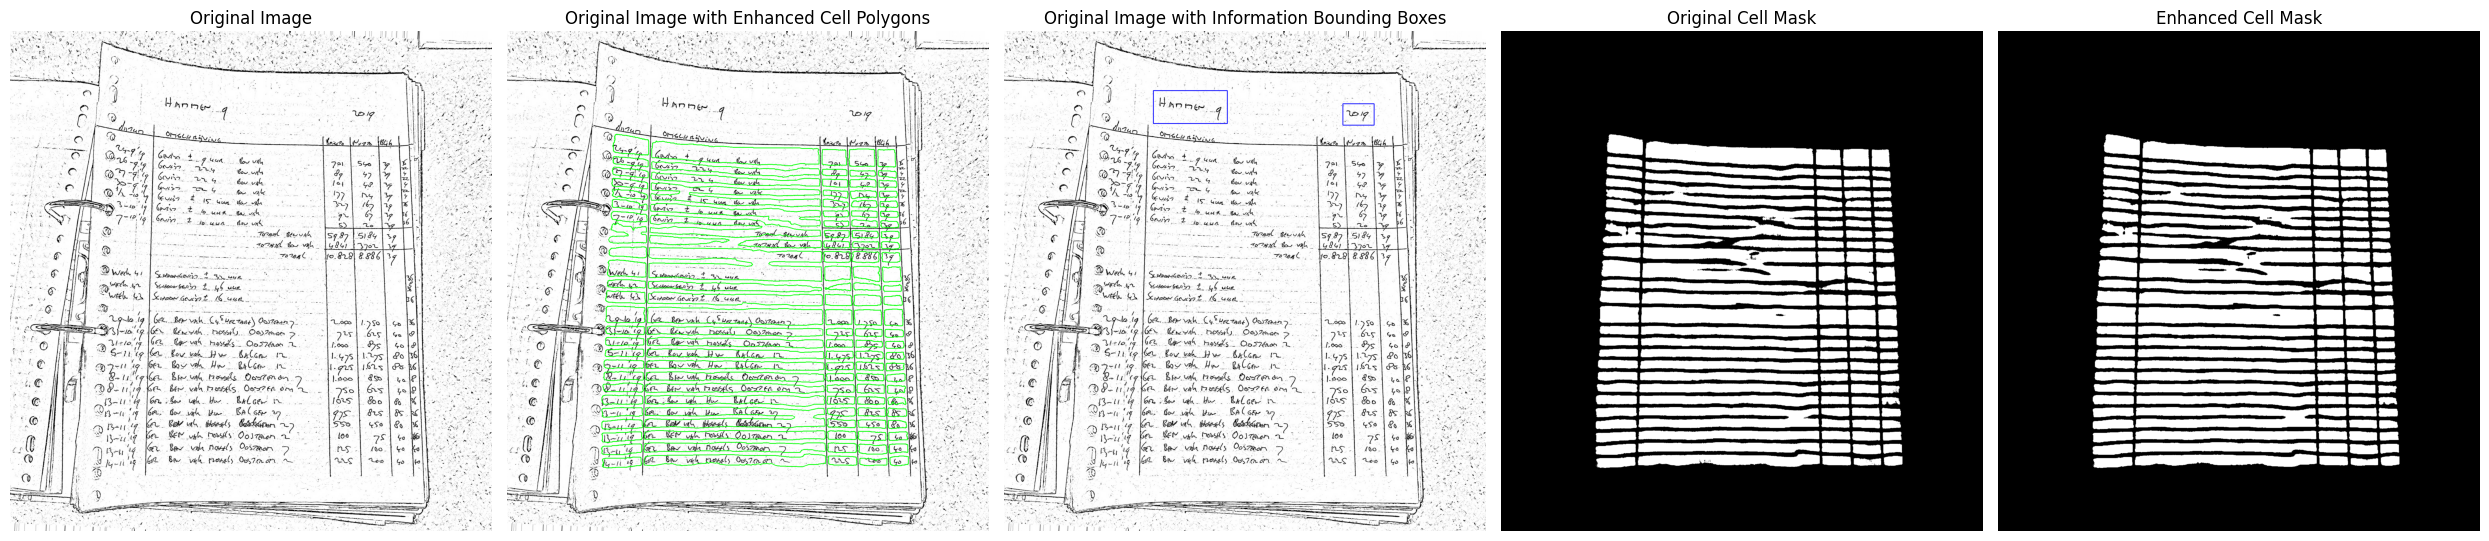

In [11]:
thresholds = {
    "cell": 0.95,
    "information": 0.4
}

image_input = IMAGE_FOLDER + "/DSC00937.JPG"

cell_polygons = visualize_uploaded_image_with_polygons(model, input_shape=(1824, 1760), thresholds=thresholds, image_input=image_input)

In [12]:
def extract_cells_to_dataframe(cell_polygons):
    def cluster_positions(positions, threshold):
        positions = np.array(positions).reshape(-1, 1)
        linkage_matrix = linkage(positions, method='single')
        clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')
        cluster_centers = [np.mean(positions[clusters == i]) for i in np.unique(clusters)]
        return sorted(cluster_centers)

    sorted_cells = sorted(cell_polygons, key=lambda p: (np.min(p[:, 1]), np.min(p[:, 0])))

    y_positions = [np.min(p[:, 1]) for p in sorted_cells]
    row_positions = cluster_positions(y_positions, threshold=7)

    x_positions = [np.min(p[:, 0]) for p in sorted_cells]
    column_positions = cluster_positions(x_positions, threshold=4)

    max_columns = len(column_positions)
    max_rows = len(row_positions)

    data = [[None for _ in range(max_columns)] for _ in range(max_rows)]

    for cell in sorted_cells:
        cell_y = np.min(cell[:, 1])
        cell_x = np.min(cell[:, 0])
        row_index = min(range(len(row_positions)), key=lambda i: abs(row_positions[i] - cell_y))
        col_index = min(range(len(column_positions)), key=lambda i: abs(column_positions[i] - cell_x))
        data[row_index][col_index] = cv2.boundingRect(cell)

    col_labels = list(string.ascii_uppercase[:max_columns])
    row_labels = [str(i + 1) for i in range(max_rows)]
    df = pd.DataFrame(data, index=row_labels, columns=col_labels)

    return df

In [13]:
df = extract_cells_to_dataframe(cell_polygons)
df = df.apply(lambda col: col.dropna().reset_index(drop=True), axis=0)

In [15]:
class CellInfo:
    def __init__(self, row_name, col_name, cell_name, polygon, bounding_box):
        self.row_name = row_name
        self.col_name = col_name
        self.cell_name = cell_name
        self.polygon = polygon
        self.bounding_box = bounding_box

In [16]:
def extract_cell_info(cell_polygons, df):
    cell_infos = []
    for row_idx, row in df.iterrows():
        for col_idx, bounding_box in row.items():
            if bounding_box is not None:
                x, y, w, h = bounding_box
                cell_name = f"{col_idx}{row_idx}"  # e.g., A1, B2
                polygon = next(
                    (poly for poly in cell_polygons if cv2.pointPolygonTest(poly, (x + w // 2, y + h // 2), False) >= 0),
                    None,
                )
                if polygon is not None:
                    cell_infos.append(
                        CellInfo(
                            row_name=row_idx,
                            col_name=col_idx,
                            cell_name=cell_name,
                            polygon=polygon,
                            bounding_box=(x, y, w, h),
                        )
                    )
    return cell_infos

In [17]:
cell_infos = extract_cell_info(cell_polygons, df)

TypeError: cannot unpack non-iterable float object

In [113]:
def create_summary_dataframe(cell_infos):
    rows = []
    for cell_info in cell_infos:
        rows.append(
            {
                "row_name": cell_info.row_name,
                "col_name": cell_info.col_name,
                "cell_name": cell_info.cell_name,
                "bounding_box": cell_info.bounding_box,
            }
        )
    return pd.DataFrame(rows)

In [114]:
summary_df = create_summary_dataframe(cell_infos)

In [115]:
summary_df

,row_name,col_name,cell_name,bounding_box
0,0,A,A0,"(160, 149, 67, 43)"
1,0,B,B0,"(231, 159, 321, 48)"
2,0,C,C0,"(555, 175, 49, 34)"
3,0,D,D0,"(608, 176, 50, 34)"
4,0,E,E0,"(663, 177, 34, 33)"
...,...,...,...,...
125,25,A,A25,"(136, 763, 76, 20)"
126,25,B,B25,"(218, 759, 346, 20)"
127,25,C,C25,"(569, 761, 54, 18)"
128,25,D,D25,"(628, 761, 53, 19)"


In [117]:
def visualize_cells_with_plotly_polygons(image_path, cell_infos):
    image = Image.open(image_path)
    image_width, image_height = image.size

    fig = go.Figure()

    fig.add_layout_image(
        dict(
            source=image,
            x=0,
            y=0,
            xref="x",
            yref="y",
            sizex=image_width,
            sizey=image_height,
            xanchor="left",
            yanchor="top",
            layer="below",
        )
    )

    for cell_info in cell_infos:
        polygon = cell_info.polygon
        x_coords = [pt[0] for pt in polygon] + [polygon[0][0]]
        y_coords = [pt[1] for pt in polygon] + [polygon[0][1]]
        fig.add_trace(
            go.Scatter(
                x=x_coords,
                y=y_coords,
                mode="lines",
                name=cell_info.cell_name,
                text=[cell_info.cell_name],
                hoverinfo="text",
                line=dict(color="red"),
            )
        )

    fig.update_xaxes(visible=False, range=[0, image_width])
    fig.update_yaxes(visible=False, range=[0, image_height])
    fig.update_layout(
        width=image_width,
        height=image_height,
        margin=dict(l=0, r=0, t=0, b=0),
        yaxis=dict(scaleanchor="x", scaleratio=1, range=[image_height, 0]),
    )
    fig.show()

In [118]:
visualize_cells_with_plotly_polygons(image_input, cell_infos)